# imports

In [30]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import copy
import numpy as np



ModuleNotFoundError: No module named 'system'

In [12]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)


# Functions

## get data functions

In [93]:
def repeat_single_value_in_column (df,value,column_name,to_print=False):
    if not isinstance(value, list) and not isinstance(value, np.ndarray):
        value = [value]

    # print(value)        
    if (len(value) != 1):
        if (to_print):
            print(f'value is not unique:{value}')
        return pd.DataFrame()
    
    df[column_name] = np.repeat(value,df.shape[0])
    return df

def get_vessel_data(vessel_data_dic,vessel_MMSI,to_print=False):
    if (1):
    # try:
        vessel_data = vessel_data_dic[vessel_MMSI]
        
        # repeat missing ID values
        ID_columns = ['IMO','Vessel_Name','Ship_Type']
        for ID_column in ID_columns:
            data = vessel_data[ID_column].loc[vessel_data[ID_column].notna()]
            data = data.unique()
            if (isinstance(data,str)):
                data = data.strip()
            # print(vessel_data.shape)
            vessel_data = repeat_single_value_in_column(vessel_data,data,ID_column)
            # print(vessel_data.shape)
            
            if (vessel_data.empty):
                if (to_print is True):
                    print(f'failed to create data base for vessel_MMSI={vessel_MMSI}')

                return vessel_data


        # take only the lines where there is a Longitude
        # print(vessel_data.shape)

        vessel_data = vessel_data[vessel_data['Longitude'].notna()]
        # print(vessel_data.shape)
 
        # sort data by time
        vessel_data = vessel_data.sort_values(by='Time')
        # print('sucess')
    # except:
    #     vessel_data = pd.DataFrame()
    #     # sys.exit(1)   
    return vessel_data




# vessel_MMSI = vessel_data_info['single'][100]
# vesel_data = get_vessel_data(vessel_data_dic,vessel_MMSI)

# vessel_data.head()




## Time functions

In [14]:
import pandas as pd

def filter_df_by_date(df, min_date, max_date, time_column='Time', date_format='%Y-%m-%d %H:%M:%S'):
    """
    Function to filter a DataFrame based on a time column and specified date range.
    
    Parameters:
    
    
    - df (pd.DataFrame): The input DataFrame.
    - min_date (str): The minimum date as a string.
    - max_date (str): The maximum date as a string.
    - time_column (str): The name of the column containing time data in the specified format.
    - date_format (str): The format of the date strings in the time column and min_date, max_date.
    
    Returns:
    - filtered_df (pd.DataFrame): The DataFrame filtered by the specified date range.
    """
    # Convert the Time column to datetime
    df[time_column] = pd.to_datetime(df[time_column], format=date_format)
    
    # Convert min_date and max_date to datetime
    min_date = pd.to_datetime(min_date, format=date_format)
    max_date = pd.to_datetime(max_date, format=date_format)
    
    # Filter the DataFrame based on the date range
    filtered_df = df[(df[time_column] >= min_date) & (df[time_column] <= max_date)]
    
    return filtered_df


# Define the minimum and maximum dates
# min_date = '2023-02-01 00:00:01'
# max_date = '2023-02-02 00:00:01'

# # Filter the DataFrame based on the date range
# df = filter_df_by_date(df, min_date, max_date)

# get_min_max_dates(df)



def time_diff_convert(time_diff,units='mins',to_round=True):
    if (not isinstance(time_diff,pd.core.series.Series)):
        is_series = False
        time_diff = pd.Series(time_diff)
    else:
        is_series = True

    if (units == 'secs'):        
        time_diff_mod = time_diff.apply(lambda x: x.total_seconds()) 
    
    if (units == 'mins'):        
        time_diff_mod = time_diff.apply(lambda x: x.total_seconds() / 60) 

    if (units == 'hours'):        
        time_diff_mod = time_diff.apply(lambda x: x.total_seconds() / 3600) 

    if (to_round):
        time_diff_mod = round(time_diff_mod)

    if (not is_series):
        time_diff_mod = time_diff_mod.values[0]        
    return time_diff_mod
    


    
def convert_time_format(df, time_column, current_format, output_format):
    """
    Function to convert the time format of a specified column in a DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - time_column (str): The name of the column containing time data.
    - current_format (str): The current format of the time data in the column.
    - output_format (str): The desired output format for the tim data.
    
    Returns:
    - df (pd.DataFrame): The DataFrame with the time column converted to the desired format.
    """
    # Convert the Time column to datetime using the current format
    df[time_column] = pd.to_datetime(df[time_column], format=current_format)
    
    # Convert the datetime to the desired output format
    df[time_column] = df[time_column].dt.strftime(output_format)
    
    return df




def get_min_max_dates(df, time_column='Time',input_format = '%Y-%m-%d %H:%M:%S',output_format='%Y-%m-%d %H:%M:%S'):
    """
    Function to get the minimum and maximum dates from a DataFrame's time column.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - time_column (str): The name of the column containing time data in '%Y-%m-%d %H:%M:%S' format.
    - output_format (str): The desired output datetime format.
    
    Returns:
    - min_date (str): The minimum date in the desired format.
    - max_date (str): The maximum date in the desired format.
    """
    # Convert the Time column to datetime
    df[time_column] = pd.to_datetime(df[time_column], format=input_format)
    
    # Get the minimum and maximum dates
    min_date = df[time_column].min().strftime(output_format)
    max_date = df[time_column].max().strftime(output_format)
    
    return min_date, max_date



# # Get the minimum and maximum dates in the desired format
# min_date, max_date = get_min_max_dates(df)

# print("Min date:", min_date)
# print("Max date:", max_date)


## Plot Functions

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator
def plot_df_column_vs_time(df,column_name,time_column_name='Time'):

    # Sample data
    dates = df[time_column_name].dt.strftime('%Y-%m-%d %H:%M:%S').to_list()
    values = df[column_name]

    # Create a figure with a larger size
    plt.figure(figsize=(7, 4))

    # Create a line plot
    plt.plot(dates, values)

    # Rotate x-tick labels by 45 degrees and change their font size
    plt.xticks(rotation=45, fontsize=12, ha='right')


    # Use MaxNLocator to reduce the number of ticks
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5))  # Adjust the number of bins as needed

    # Add labels and title
    plt.xlabel('Date and Time')
    plt.ylabel('Values')
    plt.title('Plot with Rotated and Formatted x-tick Labels')

    # Add grid
    plt.grid(True)

    # Adjust layout to prevent clipping of tick-labels
    plt.tight_layout()

    # Optionally adjust the subplots manually
    plt.subplots_adjust(bottom=0.2)

    # Show the plot
    plt.show()



# Read the file

In [16]:
# Read the file
import pandas as pd
file_path = 'C:\\gilad\\work\\tip_and_que\\data\\AIS\\TipandCue_DataSample_CSV\\'
file_name = 'exactEarth_historical_data_02_2023.csv'
file_name_full = file_path+file_name

df_org = pd.read_csv(file_name_full,low_memory=False)

# Convert the Time column from 'YYYYMMDD_HHMMSS' to 'YYYY-MM-DD HH:MM:SS'
df_org = convert_time_format(df_org, 'Time', '%Y%m%d_%H%M%S', '%Y-%m-%d %H:%M:%S')



# get a filtered version of the df

In [17]:
df = copy.deepcopy(df_org)
df_org.info()


# Define the minimum and maximum dates
min_date = '2023-02-01 00:00:01'
max_date = '2023-02-02 00:00:01'

# Filter the DataFrame based on the date range
df = filter_df_by_date(df, min_date, max_date)

# get a list of interesing columns
columns_list = ['Time','MMSI','IMO','Vessel_Name','Ship_Type','Longitude','Latitude','Message_ID']
df = df[columns_list]
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4772085 entries, 0 to 4772084
Columns: 139 entries, MMSI to spare4
dtypes: float64(121), int64(5), object(13)
memory usage: 4.9+ GB


,Time,MMSI,IMO,Vessel_Name,Ship_Type,Longitude,Latitude,Message_ID
14,2023-02-01 08:55:38,525015198,NaN,NaN,NaN,32.32015,31.2602766667,3
18,2023-02-01 15:44:31,271020158,NaN,NaN,NaN,30.58041,36.80038,18
19,2023-02-01 14:50:14,563001700,NaN,NaN,NaN,32.308625,31.0770066667,3
25,2023-02-01 20:51:17,408831000,NaN,NaN,NaN,50.6233333333,26.1866666667,27
26,2023-02-01 11:34:45,403229310,NaN,NaN,NaN,38.2179133333,23.954375,1


## Export to exell

In [18]:
# df.shape
# df.loc[:, 'index'] = df.index
# columns = ['index'] + [col for col in df.columns if col != 'index']
# df = df[columns]
# df.head()
# df.to_excel('output.xlsx', index=False)


# Dividing the df by MMSI

In [19]:
grouped = df.groupby('MMSI')

# Create a dictionary to store each vessel's data
vessel_data_dic = {vessel_MMSI: group for vessel_MMSI, group in grouped}

# Print the keys of the dictionary (MMSI values)
print(vessel_data_dic.keys())

# Access the data for a specific vessel by its MMSI
# Replace '123456789' with an actual MMSI value from your data
MMSI = 500174
vessel_data_dic[MMSI]


dict_keys([0, 135, 422, 470, 500174, 2129910, 2129930, 2129940, 2343242, 2576659, 2579999, 2717200, 2717201, 2717202, 2717215, 2717216, 2717218, 2717225, 2717226, 2717260, 2717263, 4030945, 4030946, 4031006, 4031009, 4032010, 4033000, 4033001, 4033002, 4033003, 4033004, 4033005, 4082001, 4221014, 4224200, 4225203, 4225331, 4225399, 4280001, 4282000, 4381234, 4610003, 4661001, 6221003, 6221005, 6221120, 6530000, 9125082, 9129852, 9719996, 9719997, 9719999, 12345678, 41998001, 111111111, 118170269, 118315001, 123450000, 123456789, 152487965, 200000000, 200000002, 201000000, 201892015, 205135000, 205231000, 205301810, 205373000, 205481000, 205506000, 205526000, 205706000, 207836770, 209005000, 209045000, 209048000, 209212000, 209258000, 209259000, 209343000, 209352000, 209412000, 209413000, 209483000, 209489000, 209492000, 209496000, 209511000, 209617000, 209700000, 209711693, 209722000, 209735000, 209773000, 209776000, 209815000, 209895000, 209897000, 209928000, 209931000, 209969000, 210

,Time,MMSI,IMO,Vessel_Name,Ship_Type,Longitude,Latitude,Message_ID
33788,2023-02-01 10:28:16,500174,NaN,NaN,NaN,55.0836016667,25.5407266667,18
55182,2023-02-01 11:04:16,500174,NaN,NaN,NaN,55.0836466667,25.5407466667,18
56236,2023-02-01 13:06:40,500174,NaN,NaN,NaN,55.0691916667,25.5466616667,18
133381,2023-02-01 21:15:05,500174,NaN,NaN,NaN,54.865875,25.46622,18
151965,2023-02-01 00:42:00,500174,NaN,NaN,NaN,55.06828,25.5463866667,18
...,...,...,...,...,...,...,...,...
4286107,2023-02-01 00:31:09,500174,NaN,NaN,NaN,55.0682416667,25.5463916667,18
4563701,2023-02-01 11:19:16,500174,NaN,NaN,NaN,55.0836266667,25.5407166667,18
4585622,2023-02-01 01:43:33,500174,NaN,NaN,NaN,55.08257,25.5432883333,18
4685727,2023-02-01 02:17:16,500174,NaN,NaN,NaN,55.0833533333,25.540495,18


,Time,MMSI,IMO,Vessel_Name,Ship_Type,Longitude,Latitude,Message_ID
1190609,2023-02-01 18:05:32,135,NaN,NaN,NaN,52.74783,24.1393666667,1
4381245,2023-02-01 18:05:33,135,NaN,NaN,NaN,52.74783,24.1393666667,1


In [20]:
# def get_IMO_from_MMSI(MMSI,vessel_data_dic):
# for MMSI in (vessel_data_dic.keys()):
vessel_data_info = {'Nan':[],'single':[],'multiple':[]}
for i, MMSI in enumerate(vessel_data_dic.keys()):
    if (vessel_data_dic[MMSI]['IMO'][vessel_data_dic[MMSI]['IMO'].notna()].unique().shape[0] == 0):
        vessel_data_info['Nan'].append(MMSI)
    elif (vessel_data_dic[MMSI]['IMO'][vessel_data_dic[MMSI]['IMO'].notna()].unique().shape[0] == 1):
        vessel_data_info['single'].append(MMSI)
    elif (vessel_data_dic[MMSI]['IMO'][vessel_data_dic[MMSI]['IMO'].notna()].unique().shape[0] > 1):
        vessel_data_info['multiple'].append(MMSI)

print('Nan:'+ str(len(vessel_data_info['Nan'])))
print('single:'+ str(len(vessel_data_info['single'])))
print('multiple:'+ str(len(vessel_data_info['multiple'])))




Nan:3339
single:2489
multiple:12


# create the vessels_df

In [94]:
min_data_len_thresh = 2
vessels_df = pd.DataFrame()
vessel_MMSI_prob = []
vessel_data_info_list = vessel_data_info['single']
for i,vessel_MMSI in enumerate(vessel_data_info_list):
    if (i%1000==0):
        print(f'proccessing MMSI {i} out of {len(vessel_data_info_list)}')
    vessel_data = get_vessel_data(vessel_data_dic,vessel_MMSI)
    if (vessel_data.shape[0]<min_data_len_thresh):
        vessel_MMSI_prob.append(vessel_MMSI)
    else:
        vessels_df_line = pd.DataFrame({
            'len': [vessel_data.shape[0]],  # Scalar value wrapped in a list
            'min_time':get_min_max_dates(vessel_data)[0],
            'max_time':get_min_max_dates(vessel_data)[1],
            'total_time':max(vessel_data['Time'])- min(vessel_data['Time']),
            'min_time_diff[mins]': round(np.min(time_diff_convert(vessel_data['Time'].diff()))),
            'max_time_diff[mins]': round(np.max(time_diff_convert(vessel_data['Time'].diff()))),
            'mean_time_diff[mins]': round(np.mean(time_diff_convert(vessel_data['Time'].diff()))),



            # 'data':[vessel_data]
        }, index=[vessel_MMSI])  # Providing index explicitly
        vessels_df = pd.concat([vessels_df,vessels_df_line])

vessels_df = vessels_df.sort_values(by='len',ascending=False)



                                                                     

proccessing MMSI 0 out of 2489
proccessing MMSI 1000 out of 2489
proccessing MMSI 2000 out of 2489


In [96]:
# check that all vessels were checked

print (f"total number of MMSI:{len(df['MMSI'].unique())}")
print (f"{vessels_df.shape[0]} MMSI's passed")
print (f"{len(vessel_MMSI_prob)} MMSI's failed")
i

total number of MMSI:5840
2449 MMSI's passed
40 MMSI's failed


2488

## debug a single MMSI

In [97]:
MMSI = 341021000

In [98]:
vessel_data = get_vessel_data(vessel_data_dic,MMSI)
vessel_data

,Time,MMSI,IMO,Vessel_Name,Ship_Type,Longitude,Latitude,Message_ID
2857372,2023-02-01 00:04:05,341021000,9083201.0,SANDAL,70.0,35.0289816667,32.824405,3
4438419,2023-02-01 00:16:06,341021000,9083201.0,SANDAL,70.0,35.028975,32.8244016667,3
4235386,2023-02-01 00:28:05,341021000,9083201.0,SANDAL,70.0,35.028955,32.8244116667,3
473806,2023-02-01 00:40:06,341021000,9083201.0,SANDAL,70.0,35.0289933333,32.8243933333,3
3770620,2023-02-01 00:52:07,341021000,9083201.0,SANDAL,70.0,35.0289783333,32.8244016667,3
...,...,...,...,...,...,...,...,...
2906135,2023-02-01 23:10:07,341021000,9083201.0,SANDAL,70.0,35.0289816667,32.8243966667,3
3733393,2023-02-01 23:22:06,341021000,9083201.0,SANDAL,70.0,35.0289783333,32.824385,3
956726,2023-02-01 23:34:05,341021000,9083201.0,SANDAL,70.0,35.02897,32.824385,3
4672314,2023-02-01 23:46:05,341021000,9083201.0,SANDAL,70.0,35.028965,32.8244066667,3


In [85]:
vessel_data = vessel_data_dic[MMSI]
vessel_data
# ID_column = 'IMO'
# data = vessel_data[ID_column].loc[vessel_data[ID_column].notna()]
# print(data)
# data = data.unique()
# print(data)
# if (isinstance(data,str)):
#     data = data.strip()
# print(vessel_data.shape)
# vessel_data = repeat_single_value_in_column(vessel_data,data,ID_column)
# data


,Time,MMSI,IMO,Vessel_Name,Ship_Type,Longitude,Latitude,Message_ID
33788,2023-02-01 10:28:16,500174,NaN,NaN,NaN,55.0836016667,25.5407266667,18
55182,2023-02-01 11:04:16,500174,NaN,NaN,NaN,55.0836466667,25.5407466667,18
56236,2023-02-01 13:06:40,500174,NaN,NaN,NaN,55.0691916667,25.5466616667,18
133381,2023-02-01 21:15:05,500174,NaN,NaN,NaN,54.865875,25.46622,18
151965,2023-02-01 00:42:00,500174,NaN,NaN,NaN,55.06828,25.5463866667,18
...,...,...,...,...,...,...,...,...
4286107,2023-02-01 00:31:09,500174,NaN,NaN,NaN,55.0682416667,25.5463916667,18
4563701,2023-02-01 11:19:16,500174,NaN,NaN,NaN,55.0836266667,25.5407166667,18
4585622,2023-02-01 01:43:33,500174,NaN,NaN,NaN,55.08257,25.5432883333,18
4685727,2023-02-01 02:17:16,500174,NaN,NaN,NaN,55.0833533333,25.540495,18


# plots of vessel data

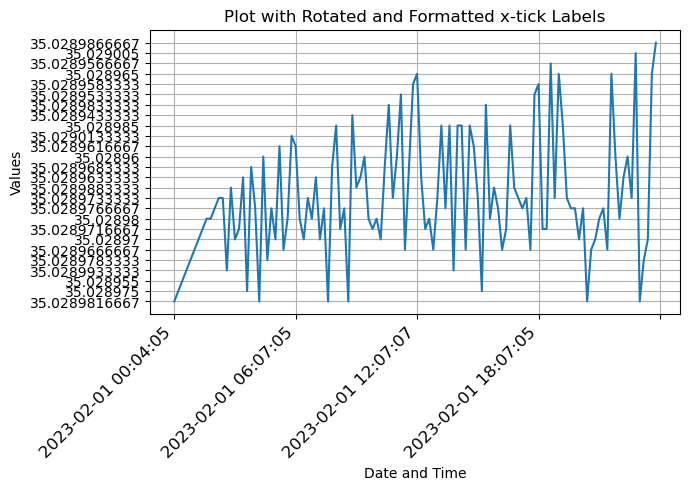

In [100]:
vessel_data = get_vessel_data(vessel_data_dic,MMSI) 

# vessel_data['Longitude'].plot(figsize=(10, 6), marker='o')

# vessel_data['Time'] = pd.to_datetime(vessel_data['Time'])

# vessel_data = vessel_data.sort_values(by='Time',ascending=True)
# print(vessel_data['Time'].iloc[0])
# print(vessel_data['Time'].iloc[vessel_data.shape[0]-1])
# plt.plot(vessel_data['Time'])
# print(type(vessel_data['Time']))

plot_df_column_vs_time(vessel_data,column_name='Longitude')

In [ ]:
vessel_data['Time'].iloc[range(0,50)]


33788     2023-02-01 10:28:16
55182     2023-02-01 11:04:16
56236     2023-02-01 13:06:40
133381    2023-02-01 21:15:05
151965    2023-02-01 00:42:00
532596    2023-02-01 01:56:16
537319    2023-02-01 13:32:43
562486    2023-02-01 10:04:54
573599    2023-02-01 12:53:36
754552    2023-02-01 13:27:58
922192    2023-02-01 00:44:08
1173793   2023-02-01 10:21:38
1180025   2023-02-01 13:38:19
1250189   2023-02-01 07:21:06
1483278   2023-02-01 14:02:08
1488409   2023-02-01 11:13:56
1489595   2023-02-01 00:07:07
1490460   2023-02-01 11:34:45
1506136   2023-02-01 01:55:32
1744504   2023-02-01 11:37:44
1746370   2023-02-01 13:20:07
1913569   2023-02-01 10:42:40
2196506   2023-02-01 13:38:01
2293469   2023-02-01 12:29:09
2305356   2023-02-01 12:16:07
2324621   2023-02-01 01:26:07
2334334   2023-02-01 12:27:39
2369960   2023-02-01 09:37:32
2563475   2023-02-01 01:36:36
2601756   2023-02-01 11:12:01
2674289   2023-02-01 01:00:13
2709625   2023-02-01 00:55:08
2821639   2023-02-01 01:22:34
2961915   

# get some statistics on vessel data


In [ ]:
vessel_data_stats = {}
vessel_data_stats['min_date'] = get_min_max_dates(vessel_data)[0]
vessel_data_stats['max_date'] = get_min_max_dates(vessel_data)[1]

print(vessel_data_stats)

In [ ]:
vessel_data.shape

# multiple IMO per MMSI analysis

In [ ]:
vessel_data = vessel_data_dic[vessel_data_info['multiple'][1]]
vessel_data.sort_values(by='IMO')

# Clean the data set

In [ ]:
# clean all nan columns
df = df.dropna(axis=1, how='all')
print(df_org.info())
print(df.info())

In [ ]:
first_index = df.index[df['IMO'].notna()][0]

# Get the next 1000 rows starting from the first index where 'IMO' is not NaN
next_1000_rows = df.iloc[first_index:first_index + 1000]

next_1000_rows.head(1000)

In [ ]:
df = df.dropna(subset=['Latitude'])
df.shape


In [ ]:
df['Latitude'].head()
IMO_vals = df['IMO'].unique()


In [ ]:
# get the MMSI values and sort them according to the size of their related df
print(df.MMSI.unique().shape)
df_MMSI = df.groupby('MMSI').size().reset_index(name='count')
df_MMSI.sort_values('count',inplace=True,ascending=False)
print(df_MMSI)


In [ ]:
def convert_to_time_num(timestamp_str):
    # Parse timestamp string to datetime object
    utc_datetime = datetime.strptime(timestamp_str, timestamp_format)
    # Convert datetime to Unix timestamp (seconds since January 1, 1970)
    return utc_datetime.timestamp()


IMO_vals = df['IMO'].unique()
print(IMO_vals)
df_IMO = df[df['IMO']==IMO_vals[150]]
# timestamp_format = "%Y%m%d_%H%M%S"

# # create a numerical time column
df_IMO['Time_num'] = df_IMO['Time'].apply(convert_to_time_num)


# df_IMO['MMSI'].unique()
print(df_IMO['Vessel_Name'].unique())
df_IMO.shape
# print (datetime.strftime(df_IMO['Time'].min(),timestamp_format))
# print (df_IMO['Time'].max())
# df_IMO.shape


# # remove all nan columns per df_MMSI
# MMSI_val = 200000000
# df_MMSI = df[df['MMSI']==MMSI_val]
# print(f'before:\n {df_MMSI.info()})')
# df_MMSI = df_MMSI.dropna(axis=1,how='all')
# print(f'after:\n {df_MMSI.info()}')
df_IMO['Time_num'].plot(kind='line', marker='o')
df_IMO.shape


In [ ]:
gdf = gpd.GeoDataFrame(
    df_IMO, 
    geometry=[Point(xy) for xy in zip(df_IMO['Longitude'], df_IMO['Latitude'])]
)

# Set the coordinate reference system (CRS)
gdf.set_crs(epsg=4326, inplace=True)
file_path = 'C:\\gilad\\work\\tip_and_que\\data\\AIS\\TipandCue_DataSample_CSV\\'
file_name = 'FALCON.geojson'
file_name_full = file_path+file_name


# gdf.to_file(file_name_full, driver='GeoJSON')
print(gdf['geometry'])



In [ ]:
df_IMO['Longitude']

In [ ]:
# Define the current format of the datetime string
current_format = '%Y%m%d_%H%M%S'

# Define the desired format for the datetime string
desired_format = '%d-%m-%Y %H:%M:%S'

# Convert datetime string from current format to desired format
datetime_obj = datetime.strptime(df_IMO['Time'].min(), current_format)
formatted_datetime_str = datetime_obj.strftime(desired_format)
print(formatted_datetime_str)

datetime_obj = datetime.strptime(df_IMO['Time'].max(), current_format)
formatted_datetime_str = datetime_obj.strftime(desired_format)


print(formatted_datetime_str)

In [ ]:
# remove all nan columns per df_MMSI
MMSI_val = 200000000
df_MMSI = df[df['MMSI']==MMSI_val]
print(f'before:\n {df_MMSI.info()})')
df_MMSI = df_MMSI.dropna(axis=1,how='all')
print(f'after:\n {df_MMSI.info()}')

# sort df by the time

In [ ]:
def convert_to_time_num(timestamp_str):
    # Parse timestamp string to datetime object
    utc_datetime = datetime.strptime(timestamp_str, timestamp_format)
    # Convert datetime to Unix timestamp (seconds since January 1, 1970)
    return utc_datetime.timestamp()


df_MMSI.head()
# Define the format of the timestamp
timestamp_format = "%Y%m%d_%H%M%S"

# create a numerical time column
df_MMSI['Time_num'] = df['Time'].apply(convert_to_time_num)

# sort df by the time
df_MMSI = df_MMSI.sort_values(by='Time_num')



In [ ]:
df_MMSI['Vessel_Name'].unique()

In [ ]:
df_MMSI.head()

In [ ]:
df_MMSI.groupby('Vessel_Name').count()



In [ ]:
df_MMSI.loc[df_MMSI['Vessel_Name'].str.contains('ZABEEL',na=False)]


In [ ]:
filtered_df = df_MMSI[df_MMSI['IMO'].notna()]
filtered_df = filtered_df[filtered_df['IMO'] != 0]
filtered_df[['Vessel_Name','IMO']].head(100)
filtered_df.sort_values('IMO')


In [ ]:

# Set display options to show all rows and columns without truncation
pd.set_option('display.max_rows', None)  # None means unlimited rows
pd.set_option('display.max_columns', None)  # None means unlimited columns
pd.set_option('display.width', None)  # Auto-detect width